# Small Example of iDLG on CIFAR10

In [13]:
from matplotlib import pyplot as plt 
import skimage 
from torch import nn 
import numpy as np 
from classes.attacks import iDLG 
import torch 
from classes.models import LeNet5

### Define Model Architecture 

In [2]:
class LeNet(nn.Module):
    def __init__(self, channel: int = 3, hidden: int = 768, num_classes: int = 10):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(channel, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5 // 2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden, num_classes)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [19]:
from tqdm import tqdm  
import torch 
import torch.nn as nn
from torchvision import transforms



class iDLG:
    def __init__(
        self,
        model,
        orig_img,
        label,
        device,
        *,
        seed: int | None = None,
        clamp: tuple[float, float] | None = (0.0, 1.0),
    ) -> None:
        # Respect provided device and keep original dtype of the model/weights
        self.device = device if isinstance(device, str) else (device.type if hasattr(device, "type") else "cpu")
        self.model = model.to(self.device)
        self.orig_img = orig_img.to(self.device)
        self.criterion = nn.CrossEntropyLoss().to(self.device)
        self.label = label.to(self.device)
        self.tt = transforms.ToPILImage()
        self.clamp = clamp

        # Align image dtype to model parameter dtype (usually float32)
        self.param_dtype = next(self.model.parameters()).dtype
        if self.orig_img.dtype != self.param_dtype:
            self.orig_img = self.orig_img.to(self.param_dtype)

        if seed is not None:
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)


    def attack(self, iterations=200):
        #iDLG training image reconstruction:
        self.model.eval()

        # compute original gradients 
        predicted = self.model(self.orig_img)
        loss = self.criterion(predicted, self.label)
        orig_grads = torch.autograd.grad(loss, self.model.parameters())
        orig_grads = list((_.detach().clone() for _ in orig_grads))

        # initialize dummy in the correct iteration, respecting the random seed
        dummy_data = (
            torch.rand(self.orig_img.size(), dtype=self.param_dtype, device=self.device)
            .requires_grad_(True)
        )

        # init with ground truth:
        label_pred = torch.argmin(torch.sum(orig_grads[-2], dim=-1), dim=-1).detach().reshape((1,)).requires_grad_(False)
        optimizer = torch.optim.LBFGS([dummy_data], lr=.1, max_iter=50, 
                              tolerance_grad=1e-09, tolerance_change=1e-11,
                              history_size=100, line_search_fn='strong_wolfe')

        history = []
        losses = []

        for iters in tqdm(range(iterations)):
            def closure():
                optimizer.zero_grad()
                dummy_pred = self.model(dummy_data)
                dummy_loss = self.criterion(dummy_pred, label_pred)
                dummy_dy_dx = torch.autograd.grad(dummy_loss, self.model.parameters(), create_graph=True)
                grad_diff = 0
                for gx, gy in zip(dummy_dy_dx, orig_grads):
                    grad_diff += ((gx - gy) ** 2).sum()
                grad_diff.backward()
                return grad_diff

            optimizer.step(closure)

            # Optional: keep dummy within valid input range
            if self.clamp is not None:
                with torch.no_grad():
                    dummy_data.clamp_(self.clamp[0], self.clamp[1])

            current_loss = closure()

            if iters % 1 == 0:
                current_loss = closure()
                losses.append(current_loss.item())
                history.append(self.tt(dummy_data[0].cpu()))

        return dummy_data.detach().numpy().squeeze(), label_pred, history, losses

### Initialize Model

In [15]:
model = LeNet5(num_classes=10)
model.load_state_dict(torch.load("state_dict_LeNet5_test.pt"))
model.eval()

/tmp/ipykernel_2556772/3154237284.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("state_dict_LeNet5_test.pt"))


LeNet5(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
  )
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (relu1): Sigmoid()
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

### Get a Datapoint 

In [24]:
# load an image from cifar10 from your dataloader 
img = skimage.io.imread("data/imagenetSubNoise/noisy0_0.0_32x32.jpg")
# Convert grayscale to RGB if needed
if img.ndim == 2:
    img = np.stack([img, img, img], axis=-1)
# Handle RGBA (4 channels) by removing alpha channel
elif img.shape[-1] == 4:
    img = img[:, :, :3]
img = img / 255.0
img = np.transpose(img, (2, 0, 1))  # HWC to CHW
input_image = torch.from_numpy(img).float().unsqueeze(0)
label = torch.Tensor([1]).long()

### Attack 

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:19<00:00, 51.15it/s]


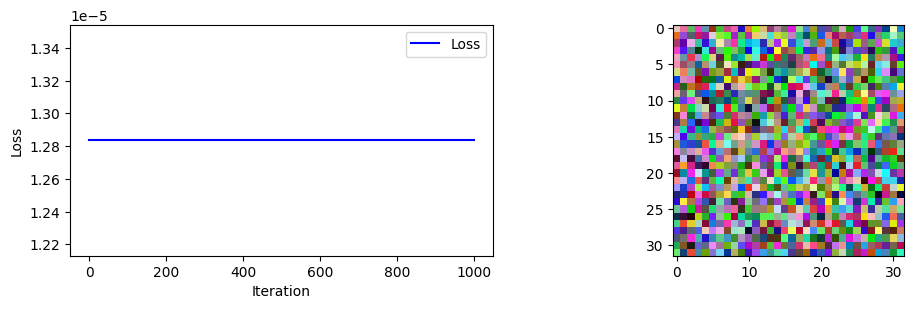

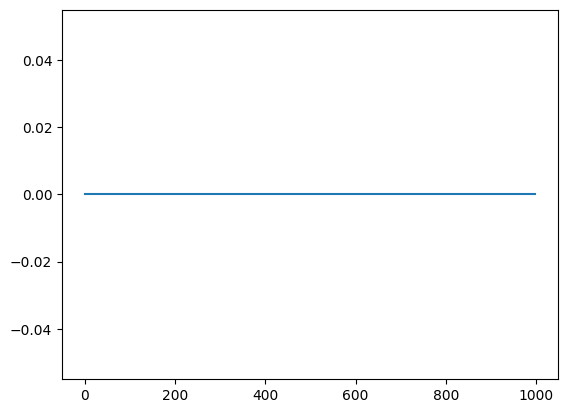

In [25]:
idlg = iDLG(model=model, device=torch.device("cpu"), orig_img = input_image, label = torch.tensor([label.item()]), clamp = (0, 1),seed=42)
dummy_data_idlg, label_pred_idlg, history_idlg, losses_idlg= idlg.attack(iterations=1000)

fig, ax = plt.subplots(1, 2, figsize = (12, 3))
ax[0].plot(losses_idlg, 'b-', label = 'Loss')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].legend()
# Convert tensor to numpy if needed
if not isinstance(dummy_data_idlg, np.ndarray):
    dummy_img = dummy_data_idlg.detach().cpu().numpy()
else:
    dummy_img = dummy_data_idlg
# Remove batch dimension if present
if dummy_img.ndim == 4:
    dummy_img = dummy_img[0]
ax[1].imshow(np.transpose(dummy_img, (1, 2, 0)))
# ax[1].imshow(history_invgra[34])
plt.show()

diff = [(np.array(history_idlg[i+1]) - np.array(history_idlg[i])).sum().item() for i in range(len(history_idlg)-1)]
plt.plot(diff)
plt.show()